In [185]:
# __future__ import first
from __future__ import annotations


from collections import defaultdict


import torch
import numpy as np
import torch.nn as nn
from torch.distributions.categorical import Categorical
import os

# Gymnasium & Minigrid 
import gymnasium as gym  # Correct way to import Gymnasium
from gymnasium.spaces import Dict, Discrete, Box
from gymnasium.wrappers import RecordVideo

from gymnasium.utils.save_video import save_video
from minigrid.core.constants import COLOR_NAMES
from minigrid.core.constants import DIR_TO_VEC
from minigrid.core.grid import Grid
from minigrid.core.actions import Actions
from minigrid.core.mission import MissionSpace
from minigrid.core.world_object import Door, Goal, Key, Wall
from minigrid.manual_control import ManualControl
from minigrid.minigrid_env import MiniGridEnv
from gymnasium.utils.play import play
import pandas as pd
import copy
# Visualization 
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from moviepy import VideoFileClip, TextClip, CompositeVideoClip
from moviepy import ImageSequenceClip
import glob
from matplotlib import rcParams
from collections import OrderedDict
from itertools import cycle

In [146]:
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = 'Arial'

In [2]:

class SimpleEnv(MiniGridEnv):
    def __init__(
            self, 
            size=10, 
            agent_start_pos=(1, 8), 
            agent_start_dir=0, 
            max_steps=256, 
            **kwargs,
    ):
        self.agent_start_pos = agent_start_pos
        self.agent_start_dir = agent_start_dir
        self.goal_pos = (8, 1)
        
        
        
        mission_space = MissionSpace(mission_func=self._gen_mission)

        super().__init__(
            mission_space=mission_space,
            grid_size=size,
            max_steps=max_steps,
            **kwargs,
        )

        self.action_space = gym.spaces.Discrete(3)
    @staticmethod
    def _gen_mission():
        return "Find the shortest path"

    def _gen_grid(self, width, height):
        #create gird
        self.grid = Grid(width, height)
        #place barrier
        self.grid.wall_rect(0, 0, width, height)
        #place goal
        self.put_obj(Goal(), 8, 1)
        #place walls
        for i in range(1, width // 2):
            self.grid.set(i, width - 4, Wall())
            self.grid.set(i + width // 2 - 1, width - 7, Wall())
        #place agent
        if self.agent_start_pos is not None:
            self.agent_pos = self.agent_start_pos #check this
            self.agent_dir = self.agent_start_dir
        else:
            self.place_agent()

        self.mission = "find the shortest path"
    
    def count_states(self):
        free_cells = sum(1 for x in range(self.grid.width)
                      for y in range(self.grid.height)
                      if not self.grid.get(x, y)) * 4
        return free_cells 


In [4]:
env = SimpleEnv(render_mode='human')
env.reset()

({'image': array([[[1, 0, 0],
          [1, 0, 0],
          [1, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[1, 0, 0],
          [1, 0, 0],
          [1, 0, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0]],
  
         [[1, 0, 0],
          [1, 0, 0],
          [1, 0, 0],
          [1, 0, 0],
          [1, 0, 0],
          [1, 0, 0],
          [1, 0, 0]],
  
         [[1, 0, 0],
          [1, 0, 0],
          [1, 0, 0],
          [1, 0, 0],
          [1, 0, 0],
          [1, 0, 0],
          [1, 0, 0]],
  
         [[2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
 

In [6]:
action = 0
obs, _, _, _, _ = env.step(action)
print("Obs shape after step:", obs["image"].shape)


Obs shape after step: (7, 7, 3)


In [110]:
"""Q learning with no explore/ exploite, Q table is calculated, and a
policy is solved for, with an additional beta term introduced
agent picks sample from the policy distribution"""
class probabilisticQlearning:
    def __init__(
        self,
        env,
        learning_rate = 0.9,
        discount_factor = 0.9,
        #epsilon = 0.5,
        epochs = 200,
        beta = 3
         
    ):
        self.env = env # MiniGrid environment called from the class Minigrid
        self.num_states = ((env.width -2) * (env.height -2) *4)
        self.num_actions = env.action_space.n
        self.Q_table = np.zeros((((env.width -2) * (env.height -2) *4), self.num_actions)) # Q table has goal states in it as well
        # print(f"Q table shape: {self.Q_table.shape}")
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor # discount factor
        # self.epsilon =  epsilon # exploration probability
        self.epochs = epochs
        self.beta = beta


        # information theoretic terms and policy related terms

        self.Pi_a_s = np.full((self.num_states, self.num_actions), 1 / self.num_actions)
        self.Pi_a = np.zeros(self.num_actions)
        self.P_s = np.zeros(self.num_states)
        self.P_s_by_s = np.zeros((self.num_states, self.num_states))
        self.P_s_given_s_a = np.zeros((self.num_states, self.num_actions, self.num_states))
        self.beta = beta
        


        self.allowed_state_idx = self.find_state_indexes(env)
        # print(f"allowed state indexes: {self.allowed_state_idx}")


    
    def position_to_state_index(self, tuple_position = None): 
        grid_width = self.env.grid.width -2
        if tuple_position is None:
            direction = self.env.agent_dir
            x, y = self.env.agent_pos

        else:
            if not isinstance(tuple_position, tuple) or len(tuple_position) != 3:
                raise ValueError(f"Invalid position format: {tuple_position}")
            x, y, direction = tuple_position
        return np.int64(((y-1) * grid_width + (x-1)) * 4 + direction) 
    
    def state_index_to_position(self, state_idx):
        """Converts a scalar state index back into (x, y, direction)."""
        grid_width = self.env.grid.width-2
        
        direction = state_idx % 4
        linear_idx = state_idx // 4

        y, x = divmod(linear_idx, grid_width)  # Convert to (x, y)
        
        return x+1, y+1, direction
    
    def find_state_indexes(self, env):
        """Counts all states except walls and barriers"""
        state_indexes_list = []
        for x in range(1, env.grid.width-1):
            for y in range(1, env.grid.height-1):
                if env.grid.get(x, y) is None: #grabs all empty spaces
                    for direction in range(4):
                        state_index = self.position_to_state_index((x, y, direction))
                        state_indexes_list.append(state_index)
        return state_indexes_list  


    def next_state_index(self, current_state_idx, action):
        # Convert current state index into (x, y, direction)
        x, y, direction = self.state_index_to_position(current_state_idx )
        
        if action == 0:  # Turn left
            direction = (direction - 1) % 4
        elif action == 1:  # Turn right
            direction = (direction + 1) % 4
        elif action == 2:  # Move forward
            if direction == 0:   # looking right increase x
                x += 1
            elif direction == 1: # looking down increase y
                y += 1
            elif direction == 2: # facing left: decrease x
                x -= 1
            elif direction == 3: # looking up: decrease y
                y -= 1
        else:
            raise ValueError(f"Invalid action: {action}")
        
        # Convert the new (x, y, direction) back to a state index.
        next_state = self.position_to_state_index((x, y, direction))
        if next_state not in self.allowed_state_idx:
            # If the next state is not allowed, return the current state
            return current_state_idx
        return next_state
    
    def find_all_next_states(self):
        """Find all possible next states for each state and action."""
        for state in self.allowed_state_idx:
            for action in range(self.num_actions):
                next_state = self.next_state_index(state, action)
                self.P_s_given_s_a[state, action, next_state] = 1
                # print(f"State {state}, Action {action} leads to State {next_state}")

    def find_connected_states(self):
        """
        Build and return a connectivity matrix P_s_by_s where the element at [state, next_state]
        is given by the probability from self.Pi_a_s for the action that leads from state to next_state.
        """
        # Loop over all states.
        for state in self.allowed_state_idx:
            # Loop over all actions for the state.
            for action in range(self.num_actions):
                # Find the next state: assume a deterministic transition where exactly one entry is 1.
                next_state = np.argmax(self.P_s_given_s_a[state, action, :])
                # Set the connectivity matrix: you might choose to sum if multiple actions lead to the same state.
                self.P_s_by_s[state, next_state] = self.Pi_a_s[state, action]
        return self.P_s_by_s

    def calculate_pi(self):
        """Calculate the policy from the Q-table."""
        denominator = np.sum((np.exp(self.beta * self.Q_table)), axis = 1, keepdims=True) # e^(-beta * Q(s,a)) summed over all actions for each state
        numerator = np.exp(self.beta * self.Q_table) # e^(-beta * Q(s,a))
        pi = numerator/denominator
        
        assert np.all(np.isclose(np.sum(pi, axis=1), np.ones(pi.shape[0]), atol=1e-5)), "Policy does not sum to 1 for all states."
        return pi
    
    
    
    def train(self, epochs):
        self.find_all_next_states() #generates self.P(s'|s,a) matrix
        
        goal_states = [self.position_to_state_index((8, 1, d)) for d in range(4)] #goal state index
        
        self.info_to_go_term = []
        self.pi_analysis_term = []

        self.steps = 1

        for epoch in range(epochs):
            
            current_state = np.random.choice(self.allowed_state_idx)
            x,y,dir = self.state_index_to_position(current_state)
            self.env.agent_pos = (x,y)
            self.env.agent_dir = dir
            # print(f"Epoch {epoch}: Starting state: {current_state}")
            # print(f"Epoch {epoch}: Starting position: {self.state_index_to_position(current_state)}")

            epoch_info_to_go = []
            epoch_pi_analysis = []

            while current_state not in goal_states:
                #get the action using pi
                action = np.random.choice(np.arange(self.num_actions), p = self.Pi_a_s[current_state])

                


                #transition to the next state
                next_obs, _, done, _, _ = self.env.step(action)

                # print(f"next_observation: {next_obs}")
                next_state = self.position_to_state_index()
                # print(f"next_state: {next_state}")
                # print(f"next  step: Agent Pos: {self.env.agent_pos}, Dir: {self.env.agent_dir}")
                #reward (-1 for each step thats not the gaol)
                reward = 0 if next_state in goal_states else -1

                self.Q_table[current_state, action] += self.learning_rate * (reward + self.discount_factor * np.max(self.Q_table[next_state]) - self.Q_table[current_state, action])



                #calculate the policy from Q table
                self.Pi_a_s = self.calculate_pi()

                #calculate the P_s (stationary distribution of states)
                initial_s = np.zeros(self.num_states)
                initial_s[current_state] = 1
                self.find_connected_states() #call this to initialize the self.P(s'|s) matrix
                self.Ps_s_matrix = np.linalg.matrix_power(self.P_s_by_s, self.steps)
                self.P_s = np.dot(initial_s .T, self.Ps_s_matrix)   #define P(s)
                assert np.isclose(np.sum(self.P_s), 1), f"Sum of P(s) is not 1: {np.sum(self.P_s)}"
                #calculate the info to go 
                info_to_go = -np.log(self.P_s[next_state] + 1e-15)  # Avoid log(0) by adding a small epsilon
                
                #calculate policy log term
                rows_of_actions_per_state = []
                for s in range(self.num_states):
                    row = self.Pi_a_s[s] * self.P_s[s]
                    # print(f'row in Pi:{self.Pi_a_s[s]} ')
                    # print(f'row {row}')
                    rows_of_actions_per_state.append(row)
                self.Pi_a = np.sum(np.asarray(rows_of_actions_per_state), axis=0)
                
                for a in range(self.num_actions):
                    pi_analysis = (np.log(self.Pi_a_s[next_state, a] + 1e-15) - np.log(self.Pi_a[a]+1e-15))

                #add calculated term into the list:
                epoch_info_to_go.append(info_to_go)
                epoch_pi_analysis.append(pi_analysis)

                #update state
                if next_state in goal_states:
                    break
                # assert(False)
                current_state = next_state
                #recaluclate P_s_by_s because its based off Pi_a_s which is based on Q_table
                self.P_s_by_s = self.find_connected_states()

            self.info_to_go_term.append(epoch_info_to_go)
            self.pi_analysis_term.append(epoch_pi_analysis)

        
        
    
    #changed policy from Q learning term to policy
    def run_policy_2(self):
        """Run the environment using the learned policy from a Q-table."""

        self.env.reset()[0]  # Reset environment
       
        current_state = self.position_to_state_index()  # Convert starting position to index
        done = False
        step_count = 0  # Track steps to prevent infinite loops



        while not done and step_count < 100:  # Prevent infinite loops
            # Debugging: Print current state and Q-values
            # print(f"Step {step_count}: State {current_state}")
            # print(f"Q-values: {self.Q_table[current_state]}")
            
            action = np.random.choice(np.arange(self.num_actions), p=self.Pi_a_s[current_state])  # Choose best action
            # print(f"Chosen action: {action}")

            # Before taking the step, print agent's current position
            # print(f"Before step: Agent Pos: {self.env.agent_pos}, Dir: {self.env.agent_dir}")

            next_obs, _, done, _, _ = self.env.step(action)  # Take action

            # After step, print agent's new position
            # print(f"After step: Agent Pos: {self.env.agent_pos}, Dir: {self.env.agent_dir}")

            next_state = self.position_to_state_index()  # Convert new state

            # Detect if the agent is looping in the same state
            # if next_state == current_state:
            #     # print(f"⚠️ Warning: Agent is stuck! Current state {current_state} is the same as next state {next_state}.")
            #     break  # Prevent infinite loop

            # self.env.render()  # Visualize movement
            # Calculate info to go term for the current step



            current_state = next_state  # Update current state
            step_count += 1
        self.env.render()



    def run_policy_stats(self):
        """
        Run the environment using the learned policy from a Q-table and collect statistics.
        """
        self.find_all_next_states() #generates P(s'|s,a) matrix
        self.find_connected_states() #call this to initialize the P(s'|s) matrix, no need to recalculate bc Pi stays the same
        


        self.env.reset()[0]  # Reset environment
        current_state = self.position_to_state_index()  # Convert starting position to index
        done = False
        step_count = 0  # Track steps to prevent infinite loops

        self.info_to_go_stats = []
        self.pi_analysis_stats = []

        while not done and step_count < 100:  # Prevent infinite loops
            # Debugging: Print current state and Q-values
            # print(f"Step {step_count}: State {current_state}")
            # print(f"Q-values: {self.Q_table[current_state]}")
            
            action = np.random.choice(np.arange(self.num_actions), p=self.Pi_a_s[current_state])  # Choose best action
            # print(f"Chosen action: {action}")

            # Before taking the step, print agent's current position
            # print(f"Before step: Agent Pos: {self.env.agent_pos}, Dir: {self.env.agent_dir}")

            next_obs, _, done, _, _ = self.env.step(action)  # Take action

            # After step, print agent's new position
            # print(f"After step: Agent Pos: {self.env.agent_pos}, Dir: {self.env.agent_dir}")

            next_state = self.position_to_state_index()  # Convert new state



            self.env.render()  # Visualize movement
            # Calculate info to go term for the current step

        #calculate the P_s (stationary distribution of states)
            initial_s = np.zeros(self.num_states)
            initial_s[current_state] = 1
            self.find_connected_states() #call this to initialize the self.P(s'|s) matrix
            self.Ps_s_matrix = np.linalg.matrix_power(self.P_s_by_s, self.steps)
            self.P_s = np.dot(initial_s .T, self.Ps_s_matrix)   #define P(s)
            assert np.isclose(np.sum(self.P_s), 1), f"Sum of P(s) is not 1: {np.sum(self.P_s)}"
            #calculate the info to go 
            info_to_go = -np.log(self.P_s[next_state] + 1e-15)  # Avoid log(0) by adding a small epsilon
            
            #calculate policy log term
            rows_of_actions_per_state = []
            for s in range(self.num_states):
                row = self.Pi_a_s[s] * self.P_s[s]
                # print(f'row in Pi:{self.Pi_a_s[s]} ')
                # print(f'row {row}')
                rows_of_actions_per_state.append(row)
            self.Pi_a = np.sum(np.asarray(rows_of_actions_per_state), axis=0)
            
            for a in range(self.num_actions):
                pi_analysis = (np.log(self.Pi_a_s[next_state, a] + 1e-15) - np.log(self.Pi_a[a]+1e-15))

            #add calculated term into the list:
            self.info_to_go_stats.append(info_to_go)
            self.pi_analysis_stats.append(pi_analysis)

            



            current_state = next_state  # Update current state
            step_count += 1

        
        



In [111]:
env = SimpleEnv(render_mode=None)
env.reset();

In [112]:
test = probabilisticQlearning(env)

In [113]:
test.train(epochs=500)  # Train the Q-learning agent for 1000 epochs

In [115]:
env_human = SimpleEnv(render_mode='human') #make same env but in human mode 

test.env= env_human #switch out the env in q training with human env
test.run_policy_2() #run the policy in the human env

In [78]:

class TransparentRecordVideo(RecordVideo):
    """RecordVideo that still exposes every attribute of the base env."""
    # 1️⃣  No change to __init__; just inherit it
    # 2️⃣  Only delegate *public* names (those not starting with "_")
    def __getattr__(self, name):
        if name.startswith("_"):          # let RecordVideo handle its internals
            raise AttributeError(name)
        return getattr(self.env, name)

In [119]:
record_env = SimpleEnv(render_mode="rgb_array")
record_env = TransparentRecordVideo(
    record_env,
    video_folder="media",
    name_prefix="test",
    episode_trigger=lambda ep: True   # record every episode
)

# ------------------------------------------------------------------
# 3) Hand that recording env to the agent and run the policy
test.env = record_env          # <‑‑ IMPORTANT: switch the env the agent uses
test.env.reset(seed=0)         # starts episode 0 and the recorder
test.run_policy_2()            # all your helpers still work: .grid, .agent_pos …

# ------------------------------------------------------------------
# 4) Close to flush the video
test.env.close()               # media/test‑episode‑0.mp4 now exists


In [80]:
env = RecordVideo(env, video_folder = 'media', name_prefix = "test")
env.start_video_recorder()
test.env = env
test.run_policy_2() #run the policy in the human env
env.close_video_recorder()
env.close()

ValueError: ('Render mode is None, which is incompatible with RecordVideo.', 'Initialize your environment with a render_mode that returns an image, such as rgb_array.')

In [34]:
test.run_policy_2()

## Plot the Information theory and Policy related term 

In [13]:
#graph the results of the training
# Plotting the info to go term over epochs
plt.figure(figsize=(12, 6))

# Plot info_to_go_term from index 0 to 499
plt.plot(test.info_to_go_term[4])

# Labeling axes and title
plt.xlabel('Epoch')
plt.ylabel('Info to Go Term')
plt.title('Info to Go Term Over Epochs')

# Display the plot
plt.show()



KeyboardInterrupt: 

In [16]:
#graph the results of the training
# Plotting the info to go term over epochs
plt.figure(figsize=(12, 6))

# Plot info_to_go_term from index 0 to 499
plt.plot(test.pi_analysis_term[1])

# Labeling axes and title
plt.xlabel('Steps')
plt.ylabel('Decision Complexity')
plt.title('Pi(a|s) Over Pi(a) per Step')

# Display the plot
plt.show()

KeyboardInterrupt: 

In [40]:
test.pi_analysis_term[0]

[np.float64(2.220446049250313e-16),
 np.float64(0.3972135219168621),
 np.float64(-0.00532949829427376),
 np.float64(2.220446049250313e-16),
 np.float64(-0.21873309406510943),
 np.float64(-4.094626933738931),
 np.float64(0.0105688856258217),
 np.float64(0.6559030830308772),
 np.float64(-0.21873309406510943),
 np.float64(-0.21873309406510943),
 np.float64(-0.21873309406510943),
 np.float64(0.6559030830308772),
 np.float64(2.220446049250313e-16),
 np.float64(0.3972135219168621),
 np.float64(-0.00532949829427376),
 np.float64(2.220446049250313e-16),
 np.float64(-0.21873309406510943),
 np.float64(-0.21873309406510943),
 np.float64(2.220446049250313e-16),
 np.float64(0.17901274720218396),
 np.float64(-0.00532949829427376),
 np.float64(1.0660067756211684),
 np.float64(-0.2835306048415993),
 np.float64(2.220446049250313e-16),
 np.float64(0.17901274720218396),
 np.float64(-0.00532949829427376),
 np.float64(-0.6739917052862713),
 np.float64(0.17901274720218385),
 np.float64(-0.6713534858850783),

## Policy and Info Terms for Trained Model

In [179]:
test.run_policy_stats()

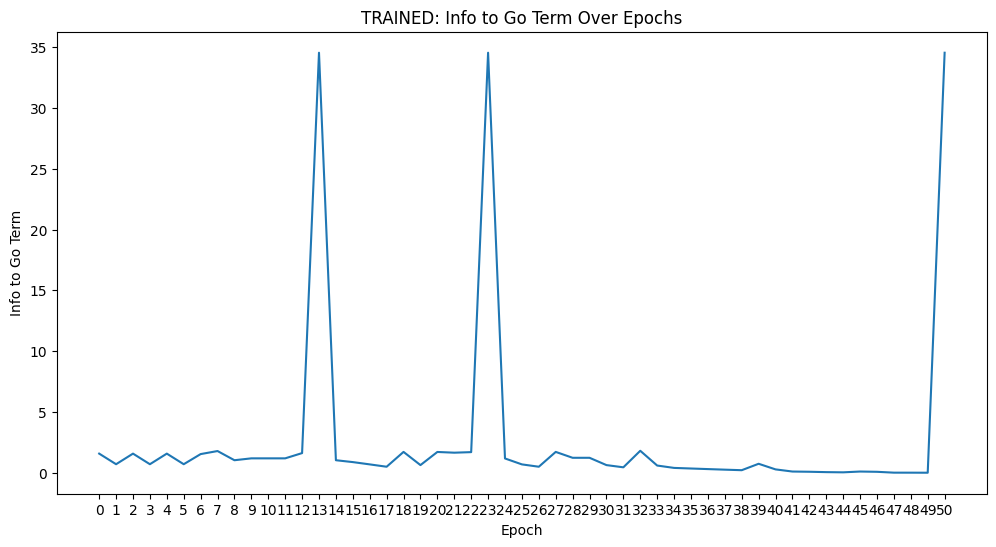

In [180]:
#graph the results of the training
# Plotting the info to go term over epochs
plt.figure(figsize=(12, 6))

# Plot info_to_go_term from index 0 to 499
plt.plot(test.info_to_go_stats)

# Labeling axes and title
plt.xlabel('Epoch')
plt.xticks([i for i in range(0, len(test.info_to_go_stats), 1)])  # Show every 1th epoch for clarity
plt.ylabel('Info to Go Term')
plt.title('TRAINED: Info to Go Term Over Epochs')

# Display the plot
plt.show()

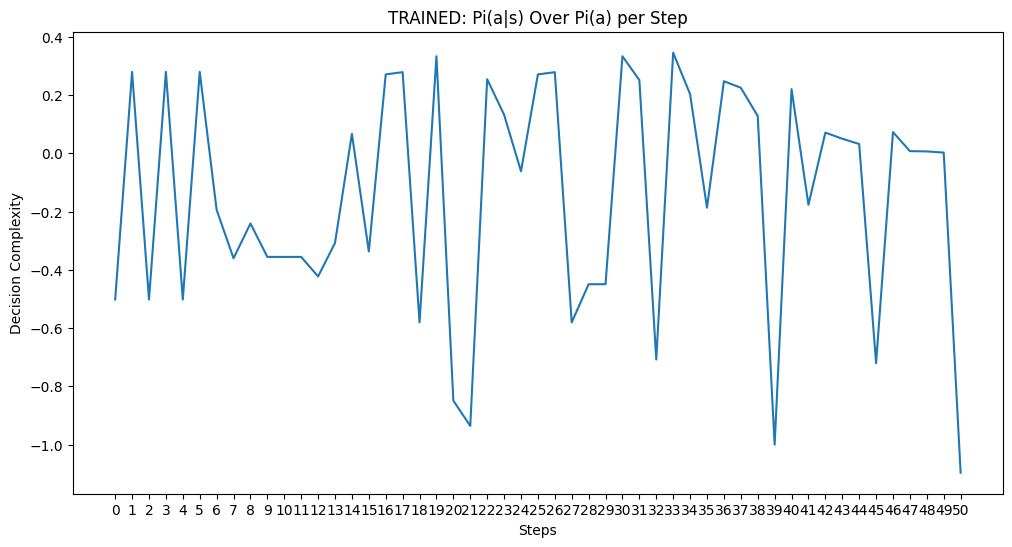

In [181]:
#graph the results of the training
# Plotting the info to go term over epochs
plt.figure(figsize=(12, 6))

# Plot info_to_go_term from index 0 to 499
plt.plot(test.pi_analysis_stats)

# Labeling axes and title
plt.xlabel('Steps')
plt.ylabel('Decision Complexity')
plt.xticks([i for i in range(0, len(test.pi_analysis_stats), 1)])  # Show every 1th step for clarity
plt.title('TRAINED: Pi(a|s) Over Pi(a) per Step')

# Display the plot
plt.show()

Bulk Processing Code

In [176]:
"""for mulitple values of beta, generate a curve """

"""Q learning with no explore/ exploite, Q table is calculated, and a
policy is solved for, with an additional beta term introduced
agent picks sample from the policy distribution"""
class probabilisticQlearning:
    def __init__(
        self,
        env,
        learning_rate = 0.9,
        discount_factor = 0.9,
        #epsilon = 0.5,
        epochs = 200,
        beta =4
        
         
    ):
        self.env = env # MiniGrid environment called from the class Minigrid
        self.num_states = ((env.width -2) * (env.height -2) *4)
        self.num_actions = env.action_space.n
        self.Q_table = np.zeros((((env.width -2) * (env.height -2) *4), self.num_actions)) # Q table has goal states in it as well
        # print(f"Q table shape: {self.Q_table.shape}")
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor # discount factor
        # self.epsilon =  epsilon # exploration probability
        self.epochs = epochs
        self.beta = beta
        


        # information theoretic terms and policy related terms

        self.Pi_a_s = np.full((self.num_states, self.num_actions), 1 / self.num_actions)
        self.Pi_a = np.zeros(self.num_actions)
        self.P_s = np.zeros(self.num_states)
        self.P_s_by_s = np.zeros((self.num_states, self.num_states))
        self.P_s_given_s_a = np.zeros((self.num_states, self.num_actions, self.num_states))
        
        


        self.allowed_state_idx = self.find_state_indexes(env)
        # print(f"allowed state indexes: {self.allowed_state_idx}")


    
    def position_to_state_index(self, tuple_position = None): 
        grid_width = self.env.grid.width -2
        if tuple_position is None:
            direction = self.env.agent_dir
            x, y = self.env.agent_pos

        else:
            if not isinstance(tuple_position, tuple) or len(tuple_position) != 3:
                raise ValueError(f"Invalid position format: {tuple_position}")
            x, y, direction = tuple_position
        return np.int64(((y-1) * grid_width + (x-1)) * 4 + direction) 
    
    def state_index_to_position(self, state_idx):
        """Converts a scalar state index back into (x, y, direction)."""
        grid_width = self.env.grid.width-2
        
        direction = state_idx % 4
        linear_idx = state_idx // 4

        y, x = divmod(linear_idx, grid_width)  # Convert to (x, y)
        
        return x+1, y+1, direction
    
    def find_state_indexes(self, env):
        """Counts all states except walls and barriers"""
        state_indexes_list = []
        for x in range(1, env.grid.width-1):
            for y in range(1, env.grid.height-1):
                if env.grid.get(x, y) is None: #grabs all empty spaces
                    for direction in range(4):
                        state_index = self.position_to_state_index((x, y, direction))
                        state_indexes_list.append(state_index)
        return state_indexes_list  


    def next_state_index(self, current_state_idx, action):
        # Convert current state index into (x, y, direction)
        x, y, direction = self.state_index_to_position(current_state_idx )
        
        if action == 0:  # Turn left
            direction = (direction - 1) % 4
        elif action == 1:  # Turn right
            direction = (direction + 1) % 4
        elif action == 2:  # Move forward
            if direction == 0:   # looking right increase x
                x += 1
            elif direction == 1: # looking down increase y
                y += 1
            elif direction == 2: # facing left: decrease x
                x -= 1
            elif direction == 3: # looking up: decrease y
                y -= 1
        else:
            raise ValueError(f"Invalid action: {action}")
        
        # Convert the new (x, y, direction) back to a state index.
        next_state = self.position_to_state_index((x, y, direction))
        if next_state not in self.allowed_state_idx:
            # If the next state is not allowed, return the current state
            return current_state_idx
        return next_state
    
    def find_all_next_states(self):
        """Find all possible next states for each state and action."""
        for state in self.allowed_state_idx:
            for action in range(self.num_actions):
                next_state = self.next_state_index(state, action)
                self.P_s_given_s_a[state, action, next_state] = 1
                # print(f"State {state}, Action {action} leads to State {next_state}")

    def find_connected_states(self):
        """
        Build and return a connectivity matrix P_s_by_s where the element at [state, next_state]
        is given by the probability from self.Pi_a_s for the action that leads from state to next_state.
        """
        # Reset the connectivity matrix at the beginning.
        self.P_s_by_s = np.zeros((self.num_states, self.num_states))
        # Loop over all states.
        for state in self.allowed_state_idx:
            # Loop over all actions for the state.
            for action in range(self.num_actions):
                # Find the next state: assume a deterministic transition where exactly one entry is 1.
                next_state = np.argmax(self.P_s_given_s_a[state, action, :])
                # Set the connectivity matrix: you might choose to sum if multiple actions lead to the same state.
                self.P_s_by_s[state, next_state] += self.Pi_a_s[state, action]
        return self.P_s_by_s

    def calculate_pi(self):
        """Calculate the policy from the Q-table."""
        denominator = np.sum((np.exp(self.beta * self.Q_table)), axis = 1, keepdims=True) # e^(-beta * Q(s,a)) summed over all actions for each state
        numerator = np.exp(self.beta * self.Q_table) # e^(-beta * Q(s,a))
        pi = numerator/denominator
        
        assert np.all(np.isclose(np.sum(pi, axis=1), np.ones(pi.shape[0]), atol=1e-5)), "Policy does not sum to 1 for all states."
        return pi
    
    
    
    def train(self, epochs):
        self.find_all_next_states() #generates self.P(s'|s,a) matrix
        
        goal_states = [self.position_to_state_index((8, 1, d)) for d in range(4)] #goal state index
        
        self.info_to_go_term = []
        self.pi_analysis_term = []

        self.steps = 1

        for epoch in range(epochs):
            
            current_state = np.random.choice(self.allowed_state_idx)
            x,y,dir = self.state_index_to_position(current_state)
            self.env.agent_pos = (x,y)
            self.env.agent_dir = dir
            # print(f"Epoch {epoch}: Starting state: {current_state}")
            # print(f"Epoch {epoch}: Starting position: {self.state_index_to_position(current_state)}")

            epoch_info_to_go = []
            epoch_pi_analysis = []
            initial_s = np.zeros(self.num_states)
            initial_s[current_state] = 1

            while current_state not in goal_states:
                #get the action using pi
                action = np.random.choice(np.arange(self.num_actions), p = self.Pi_a_s[current_state])

                


                #transition to the next state
                next_obs, _, done, _, _ = self.env.step(action)

                # print(f"next_observation: {next_obs}")
                next_state = self.position_to_state_index()
                # print(f"next_state: {next_state}")
                # print(f"next  step: Agent Pos: {self.env.agent_pos}, Dir: {self.env.agent_dir}")
                #reward (-1 for each step thats not the gaol)
                reward = 0 if next_state in goal_states else -1

                self.Q_table[current_state, action] += self.learning_rate * (reward + self.discount_factor * np.max(self.Q_table[next_state]) - self.Q_table[current_state, action])



                #calculate the policy from Q table
                self.Pi_a_s = self.calculate_pi()

                #calculate the P_s (stationary distribution of states)
                
                self.find_connected_states() #call this to initialize the self.P(s'|s) matrix
                self.Ps_s_matrix = np.linalg.matrix_power(self.P_s_by_s, self.steps)
                self.P_s = np.dot(initial_s .T, self.Ps_s_matrix)   #define P(s)
                assert np.isclose(np.sum(self.P_s), 1), f"Sum of P(s) is not 1: {np.sum(self.P_s)}"
                #calculate the info to go 
                info_to_go = -np.log(self.P_s[next_state] + 1e-15)  # Avoid log(0) by adding a small epsilon
                
                #calculate policy log term
                rows_of_actions_per_state = []
                for s in range(self.num_states):
                    row = self.Pi_a_s[s] * self.P_s[s]
                    # print(f'row in Pi:{self.Pi_a_s[s]} ')
                    # print(f'row {row}')
                    rows_of_actions_per_state.append(row)
                self.Pi_a = np.sum(np.asarray(rows_of_actions_per_state), axis=0)
                
                for a in range(self.num_actions):
                    pi_analysis = (np.log(self.Pi_a_s[next_state, a] + 1e-15) - np.log(self.Pi_a[a]+1e-15))

                #add calculated term into the list:
                epoch_info_to_go.append(info_to_go)
                epoch_pi_analysis.append(pi_analysis)

                #update state
                if next_state in goal_states:
                    break
                # assert(False)
                current_state = next_state
                #recaluclate P_s_by_s because its based off Pi_a_s which is based on Q_table
                self.P_s_by_s = self.find_connected_states()

            self.info_to_go_term.append(epoch_info_to_go)
            self.pi_analysis_term.append(epoch_pi_analysis)

        
     #########################################################################################################################
    #Running Policy with stats, obtaining mulitple beta runs, various plotting functions
    #########################################################################################################################   
    
    #changed policy from Q learning term to policy
    def run_policy_2(self):
        """Run the environment using the learned policy from a Q-table."""

        self.env.reset()[0]  # Reset environment
        current_state = self.position_to_state_index()  # Convert starting position to index
        done = False
        self.step_count = 0  # Track steps to prevent infinite loops



        while not done and self.step_count < 100:  # Prevent infinite loops
            # Debugging: Print current state and Q-values
            # print(f"Step {step_count}: State {current_state}")
            # print(f"Q-values: {self.Q_table[current_state]}")
            
            action = np.random.choice(np.arange(self.num_actions), p=self.Pi_a_s[current_state])  # Choose best action
            # print(f"Chosen action: {action}")

            # Before taking the step, print agent's current position
            # print(f"Before step: Agent Pos: {self.env.agent_pos}, Dir: {self.env.agent_dir}")

            next_obs, _, done, _, _ = self.env.step(action)  # Take action

            # After step, print agent's new position
            # print(f"After step: Agent Pos: {self.env.agent_pos}, Dir: {self.env.agent_dir}")

            next_state = self.position_to_state_index()  # Convert new state

            # Detect if the agent is looping in the same state
            # if next_state == current_state:
            #     # print(f"⚠️ Warning: Agent is stuck! Current state {current_state} is the same as next state {next_state}.")
            #     break  # Prevent infinite loop

            self.env.render()  # Visualize movement
            # Calculate info to go term for the current step



            current_state = next_state  # Update current state
            self.step_count += 1

    def get_P_st(self, T):
        self.env.reset()[0]  # Reset environment
        initial_state = self.position_to_state_index()  # Convert starting position to index
        initial_s = np.zeros(self.num_states)
        initial_s[initial_state] = 1
        self.find_connected_states()

        Ps_s_matrix = np.linalg.matrix_power(self.P_s_by_s, T)
        P_s = np.dot(initial_s.T, Ps_s_matrix)   #define P(s)

        assert(np.isclose(np.sum(P_s), 1)), f"Sum of P(s) is not 1: {np.sum(P_s)}"

        return P_s
    
    def alt_P_r_s(self, state_probabilities):
        """Separate from the state index the actual position and direction of the agent."""
        self.positions_directions = {}
        self.positions = []
        self.directions = []
        for state_idx, probability in enumerate(state_probabilities):
            x, y, direction = self.state_index_to_position(state_idx)
            self.positions.append((x, y))
            self.directions.append(direction)
            
            # Store in a dictionary under 'position' and 'direction'
            self.positions_directions[state_idx] = {
                "position": (x, y),
                "direction": direction,
                "probability": probability
            }

    def get_pdl(self, T):
        self.positions_directions_list = []
        for t in range(T):
            tmp_probs = self.get_P_st(t)
            self.alt_P_r_s(tmp_probs)
            self.position_to_state_index
            self.positions_directions_list.append(copy.deepcopy(self.positions_directions)) 

    def get_neglog_pdl(self, T):
        self.positions_directions_list = []
        for t in range(T):
            tmp_probs = self.get_P_st(t)
            self.alt_P_r_s(-np.log((tmp_probs)+ 1e-15))
            self.position_to_state_index
            self.positions_directions_list.append(copy.deepcopy(self.positions_directions)) 

    def get_decision_term(self, T):
        decision_term = []
        for a in range(self.num_actions):

            decision_term += (np.log(self.Pi_a_s[self.next_state , a] + 1e-15) - np.log(self.Pi_a) + 1e-15) * self.Pi_a_s[self.next_state, a]


    def run_policy_stats(self):
        """
        Run the environment using the learned policy from a Q-table and collect statistics.
        """
        self.find_all_next_states() #generates P(s'|s,a) matrix
        # self.find_connected_states() #call this to initialize the P(s'|s) matrix, no need to recalculate bc Pi stays the same
        


        self.env.reset()[0]  # Reset environment
        current_state = self.position_to_state_index()  # Convert starting position to index
        done = False
        step_count = 0  # Track steps to prevent infinite loops

        self.info_to_go_stats = []
        self.pi_analysis_stats = []
        

        self.positions_directions_list = []         
        while not done and step_count < 100:  # Prevent infinite loops
            # Debugging: Print current state and Q-values
            # print(f"Step {step_count}: State {current_state}")
            # print(f"Q-values: {self.Q_table[current_state]}")
            
            action = np.random.choice(np.arange(self.num_actions), p=self.Pi_a_s[current_state])  # Choose best action
            # print(f"Chosen action: {action}")

            # Before taking the step, print agent's current position
            # print(f"Before step: Agent Pos: {self.env.agent_pos}, Dir: {self.env.agent_dir}")

            next_obs, _, done, _, _ = self.env.step(action)  # Take action

            # After step, print agent's new position
            # print(f"After step: Agent Pos: {self.env.agent_pos}, Dir: {self.env.agent_dir}")

            next_state = self.position_to_state_index()  # Convert new state



            self.env.render()  # Visualize movement
            # Calculate info to go term for the current step

        #calculate the P_s (stationary distribution of states)
            #call this to initialize the self.P(s'|s) matrix
            initial_s = np.zeros(self.num_states)
            initial_s[current_state] = 1
            self.find_connected_states() 
            self.Ps_s_matrix = np.linalg.matrix_power(self.P_s_by_s, self.steps)
            self.P_s = np.dot(initial_s.T, self.Ps_s_matrix)   #define P(s)
            assert np.isclose(np.sum(self.P_s), 1), f"Sum of P(s) is not 1: {np.sum(self.P_s)}"
            #calculate the info to go 
            info_to_go = -np.log(self.P_s[next_state] + 1e-15)  # Avoid log(0) by adding a small epsilon
            
            #calculate policy log term
            rows_of_actions_per_state = []
            for s in range(self.num_states):
                row = self.Pi_a_s[s] * self.P_s[s]
                # print(f'row in Pi:{self.Pi_a_s[s]} ')
                # print(f'row {row}')
                rows_of_actions_per_state.append(row)
            self.Pi_a = np.sum(np.asarray(rows_of_actions_per_state), axis=0)
            
            for a in range(self.num_actions):
                pi_analysis = (np.log(self.Pi_a_s[next_state, a] + 1e-15) - np.log(self.Pi_a[a]+1e-15))

            #add calculated term into the list:
            self.info_to_go_stats.append(info_to_go)
            self.pi_analysis_stats.append(pi_analysis)

            self.P_r_s(epochs= False) 
            self.positions_directions_list.append(copy.deepcopy(self.positions_directions)) 




            current_state = next_state  # Update current state
            
            step_count += 1

        
    def run_mulitple_betas(self, runs_per_beta = 10):
        """
        Run the training function for mulitple betas, save the policies for each beta, and then
        use the trained policies to run the test_policy function and collect the length of
        the path taken, then plot.
        """
        
        betas = np.arange(0.5, 10, 0.5)
        step_count_per_beta = {}

        for beta in betas:
            # Make a FRESH instance for each beta
            model_for_beta = probabilisticQlearning(env, beta=beta, epochs=500)

            # Train from scratch inside that instance
            model_for_beta.train(epochs=500)

            # Evaluate it runs_per_beta times
            step_counts = []
            for _ in range(runs_per_beta):
                model_for_beta.env.reset()
                model_for_beta.run_policy_2()
                step_counts.append(model_for_beta.step_count)

            step_count_per_beta[beta] = step_counts

        return step_count_per_beta
        
    def run_multiple_betas_epochs(self,
                              runs_per_beta=10,
                              betas=None,
                              epochs=500):

        # -------------------- set up β list --------------------
        if betas is None:
            betas = np.arange(0.5, 10, 0.5)
        betas = np.asarray(betas)

        # -------------------- align epochs ---------------------
        if isinstance(epochs, (int, float)):           # broadcast single value
            epochs_list = [int(epochs)] * len(betas)
        else:
            if len(epochs) != len(betas):
                raise ValueError("epochs must be a single int or same length as betas")
            epochs_list = list(epochs)

        step_count_per_beta = OrderedDict()

        # -------------------- main loop ------------------------
        for beta, n_epochs in zip(betas, epochs_list):
            model = probabilisticQlearning(env, beta=beta, epochs=n_epochs)
            model.train(epochs=n_epochs)

            counts = []
            for _ in range(runs_per_beta):
                model.env.reset()
                model.run_policy_2()          # assumes this sets model.step_count
                counts.append(model.step_count)

            step_count_per_beta[beta] = counts

        return step_count_per_beta
    
            
    def P_r_s(self, epochs = True):
        """Separate from the state index the actual position and direction of the agent."""
        self.positions_directions = {}
        state_probabilities = self.P_s
        self.positions = []
        self.directions = []
        if epochs:
            for epoch in range(self.epochs):
                for state_idx, probability in enumerate(state_probabilities):
                    x, y, direction = self.state_index_to_position(state_idx)
                    self.positions.append((x, y))
                    self.directions.append(direction)
                    
                    # Store in a dictionary under 'position' and 'direction'
                    self.positions_directions[state_idx] = {
                        "epoch": epoch,
                        "position": (x, y),
                        "direction": direction,
                        "probability": probability
                    }
        else:
            for state_idx, probability in enumerate(state_probabilities):
                    x, y, direction = self.state_index_to_position(state_idx)
                    self.positions.append((x, y))
                    self.directions.append(direction)
                    
                    # Store in a dictionary under 'position' and 'direction'
                    self.positions_directions[state_idx] = {
                        "position": (x, y),
                        "direction": direction,
                        "probability": probability
                    }



    def plot_all_heatmaps(self):
        """
        Plot a heatmap for each step of the simulation using the data stored 
        in self.positions_directions_list. Each heatmap shows the probability (from P_s)
        at the corresponding x, y positions, and prints the sum of all probabilities.
        """
        # First, determine the grid size across all steps
        all_positions = []
        for pos_dict in self.positions_directions_list:
            for entry in pos_dict.values():
                all_positions.append(entry["position"])
        
        # Determine grid dimensions
        max_x = max(pos[0] for pos in all_positions)
        max_y = max(pos[1] for pos in all_positions)
        
        # Create a heatmap for each step stored
        for step, pos_dict in enumerate(self.positions_directions_list):
            # Initialize a grid with zeros.
            # Note: We use (max_y+1, max_x+1) since positions are assumed to start at 0.
            grid = np.zeros((max_y + 1, max_x + 1))
            
            # Fill the grid by *adding* the probabilities from pos_dict
            for entry in pos_dict.values():
                x, y = entry["position"]
                probability = entry["probability"]
                grid[y, x] += probability  # Use += to accumulate probabilities if positions repeat

            # Calculate the total probability for this heatmap
            total_probability = grid.sum()
            print(f"Step {step}: Total probability = {total_probability:.4f}")
            
            # Plot the heatmap for the current step.
            plt.figure()
            plt.imshow(grid, origin='upper', cmap='hot', interpolation='nearest')
            plt.title(f"Heatmap at Step {step} (Total Probability: {total_probability:.4f})")
            plt.xlabel("X position")
            plt.ylabel("Y position")
            plt.colorbar(label="Probability")
            plt.show()

    def plot_all_heatmaps1(self):
        """
        Plot a heatmap for each step of the simulation using the data stored 
        in self.positions_directions_list. Each heatmap shows the probability (from P_s)
        at the corresponding x, y positions, and prints the sum of all probabilities.
        The color bar range is standardized across all plots using the global maximum value.
        """
        # First, determine the grid size across all steps
        all_positions = []
        for pos_dict in self.positions_directions_list:
            for entry in pos_dict.values():
                all_positions.append(entry["position"])
        
        # Determine grid dimensions
        max_x = max(pos[0] for pos in all_positions)
        max_y = max(pos[1] for pos in all_positions)

        # Create a heatmap for each step using the standardized color range.
        for step, pos_dict in enumerate(self.positions_directions_list):
            grid = np.zeros((max_y + 2, max_x + 2))
            for entry in pos_dict.values():
                x, y = entry["position"]
                probability = entry["probability"]
                grid[y, x] += probability

            total_probability = grid.sum()
            print(f"Step {step}: Total probability = {total_probability:.4f}")

            # Plot the heatmap: set vmin to 0 and vmax to the computed global maximum.
            plt.figure()
            plt.imshow(grid, origin='upper', cmap='hot', interpolation='nearest')
            plt.title(f"Information Gained by Environment: Step {step} ")
            
            plt.xlabel("X position")
            plt.ylabel("Y position")
            plt.colorbar(label="-log(P(s)")
            plt.show()

    def save_all_heatmaps(self, folder_name):
        """
        Generate and save a heatmap for each simulation step.
        
        Parameters:
        - folder_name: The directory in which images are saved.
        
        Each heatmap is saved as a PNG file (e.g. "heatmap_000.png").
        """
        # Ensure the folder exists
        if not os.path.exists(folder_name):
            os.makedirs(folder_name)
        
        # Determine grid dimensions from all positions
        all_positions = []
        for pos_dict in self.positions_directions_list:
            for entry in pos_dict.values():
                all_positions.append(entry["position"])
        
        max_x = max(pos[0] for pos in all_positions)
        max_y = max(pos[1] for pos in all_positions)

        fig_size = (6, 6)
        
        # Generate and save a heatmap for each step
        for step, pos_dict in enumerate(self.positions_directions_list):
            # Initialize a grid (with zeros) of appropriate size.
            grid = np.zeros((max_y + 2, max_x + 2))
            
            # Populate the grid by adding probabilities
            for entry in pos_dict.values():
                x, y = entry["position"]
                probability = entry["probability"]
                grid[y, x] += probability
            
            # Calculate the total probability for this heatmap
            total_probability = grid.sum()
            print(f"Step {step}: Total probability = {total_probability:.4f}")
            
            # Create the figure for the heatmap
            plt.figure(figsize = fig_size)
            plt.imshow(grid, origin='upper', cmap='hot', interpolation='nearest')
            plt.title(f"Information Gained by Environment: Step {step} ")
            plt.xlabel("X position")
            plt.ylabel("Y position")
            plt.colorbar(label="-log(P(s)")
            
            # Build the file path; file names are zero-padded for proper sorting.
            file_path = os.path.join(folder_name, f"heatmap_{step:03d}.png")
            plt.savefig(file_path)
            plt.close()  # Close the figure to free memory


            








In [129]:
env = SimpleEnv(render_mode=None)
env.reset();

In [123]:
test = probabilisticQlearning(env)

In [8]:
test.train(epochs=500)  # Train the Q-learning agent for 1000 epochs

In [11]:
test.get_pdl(50)

In [170]:
test.get_neglog_pdl(50)

In [10]:
test.P_s_by_s = test.find_connected_states()

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

ax.imshow(np.linalg.matrix_power(test.P_s_by_s.T, 5), cmap='Greys')

In [211]:
np.nonzero(test.P_s) 

(array([24, 25, 27]),)

In [62]:
test.run_policy_stats()

In [ ]:
test.plot_all_heatmaps1()



In [ ]:
test.save_all_heatmaps(folder_name="enivorment_decison_heatmaps")

In [ ]:
def clear_folder(folder_name):
    files = glob.glob(os.path.join(folder_name, "*.png"))
    for f in files:
        os.remove(f)

In [124]:
clear_folder('heatmaps')

In [164]:
def create_video_from_images(image_folder, output_file, fps=2):
    """
    Create a video from a sequence of images saved in a folder.
    
    Parameters:
    - image_folder: Folder where the heatmap images are stored.
    - output_file: Path for the output video file (e.g., "simulation.mp4").
    - fps: Frames per second for the output video.
    """
    # Get a sorted list of image files from the folder
    image_pattern = os.path.join(image_folder, "heatmap_*.png")
    image_files = sorted(glob.glob(image_pattern))
    
    # Create a clip from the sequence of images
    clip = ImageSequenceClip(image_files, fps=fps)
    
    # Write the video file
    clip.write_videofile(output_file, codec='libx264', audio_codec="aac" )

In [174]:
# Usage example:
create_video_from_images("enivorment_decison_heatmaps", "env_beta5.mp4", fps=4)

MoviePy - Building video env_beta5.mp4.
MoviePy - Writing video env_beta5.mp4



MoviePy - Done !
MoviePy - video ready env_beta5.mp4


In [177]:
beta_explore = probabilisticQlearning(env)

In [ ]:
beta_dictionary_20 = beta_explore.run_mulitple_betas(runs_per_beta = 20)

In [126]:
beta_dictionary

{np.float64(0.5): np.float64(99.5),
 np.float64(1.0): np.float64(82.9),
 np.float64(1.5): np.float64(59.9),
 np.float64(2.0): np.float64(49.8),
 np.float64(2.5): np.float64(59.3),
 np.float64(3.0): np.float64(38.8),
 np.float64(3.5): np.float64(36.0),
 np.float64(4.0): np.float64(35.4),
 np.float64(4.5): np.float64(31.0),
 np.float64(5.0): np.float64(30.1),
 np.float64(5.5): np.float64(25.1),
 np.float64(6.0): np.float64(23.2),
 np.float64(6.5): np.float64(25.7),
 np.float64(7.0): np.float64(21.3),
 np.float64(7.5): np.float64(24.6),
 np.float64(8.0): np.float64(26.7),
 np.float64(8.5): np.float64(27.5),
 np.float64(9.0): np.float64(26.6),
 np.float64(9.5): np.float64(24.2)}

In [184]:
betas         = np.arange(0.5, 10, 0.5)      # 19 β’s
epoch_options = [100, 200,  300,    # 19 epoch counts
                  400,  500
                 ]

grid_results = {}                 # epoch → {β: [20 step counts]}

for n_epochs in epoch_options:
    grid_results[n_epochs] = beta_explore.run_multiple_betas_epochs(            # raw MiniGrid env
        betas=betas,
        epochs=n_epochs           # single int → broadcast to all β’s
    )

/var/folders/4x/v6r504vx43l3xd43p7kmbr400000gn/T/ipykernel_99510/3516594616.py:22: UserWarning: Glyph 8239 (\N{NARROW NO-BREAK SPACE}) missing from font(s) Arial.
  fig.tight_layout()


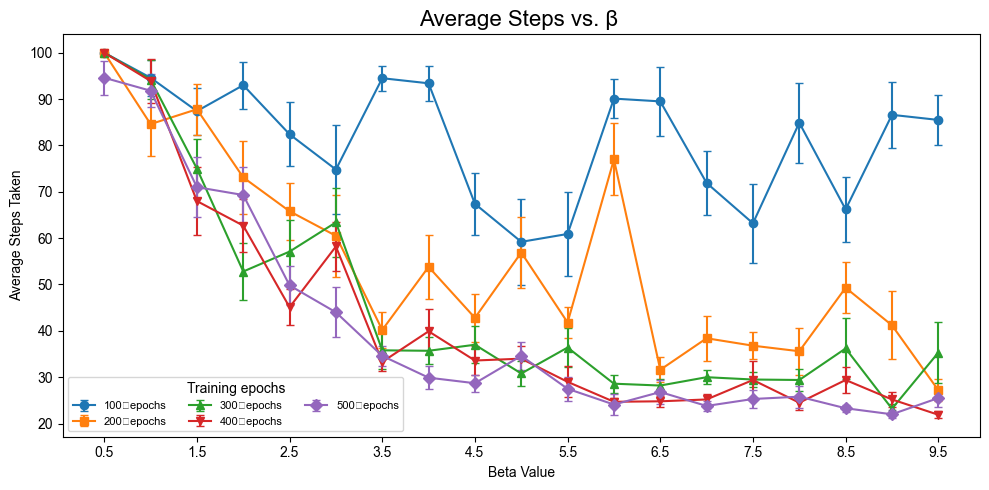

: 

In [192]:
fig, ax = plt.subplots(figsize=(10, 5))
marker_cycle = cycle(['o', 's', '^', 'v', 'D', 'P', '*'])    # varied markers

for n_epochs in epoch_options:
    beta_dict = grid_results[n_epochs]
    means = [np.mean(beta_dict[β]) for β in betas]
    sems  = [np.std(beta_dict[β], ddof=1) / np.sqrt(len(beta_dict[β]))
             for β in betas]

    ax.errorbar(betas, means, yerr=sems,
                fmt='-',
                marker=next(marker_cycle),
                capsize=3,
                label=f'{n_epochs} epochs')

ax.set_xlabel('Beta Value')
ax.set_ylabel('Average Steps Taken')
ax.set_title('Average Steps vs. β ', fontsize=16)
ax.set_xticks(np.arange(0.5, 10, 1))
# ax.grid(alpha=0.25)
ax.legend(ncol=3, title='Training epochs', fontsize=8)
fig.tight_layout()
plt.show()

In [183]:
results

OrderedDict([(np.float64(0.5),
              [100,
               100,
               96,
               100,
               85,
               100,
               100,
               100,
               100,
               100,
               100,
               100,
               100,
               100,
               100,
               100,
               100,
               100,
               100,
               100]),
             (np.float64(1.0),
              [100,
               100,
               95,
               100,
               100,
               52,
               100,
               100,
               88,
               100,
               100,
               100,
               100,
               100,
               100,
               58,
               100,
               100,
               100,
               60]),
             (np.float64(1.5),
              [97,
               35,
               100,
               100,
               68,
             

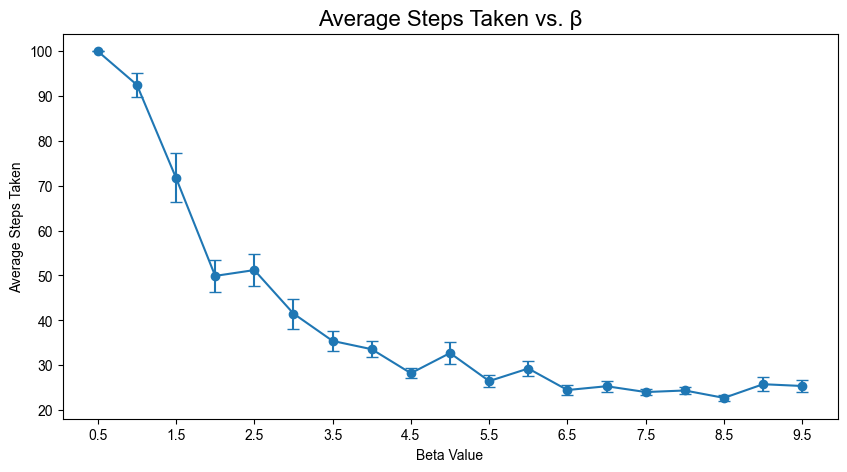

In [179]:

betas = sorted(beta_dictionary_20.keys())                     # x‑axis
means = [np.mean(beta_dictionary_20[β]) for β in betas]       # y‑values
sems  = [np.std (beta_dictionary_20[β], ddof=1) /             # error bars
         np.sqrt(len(beta_dictionary_20[β])) for β in betas]

# (optional) flip sign if you really want negative values
# means = [-m for m in means]
plt.figure(figsize=(10, 5))
plt.errorbar(betas, means,
             yerr=sems, fmt='-o', capsize=4)  # fmt='-o' gives line+markers
plt.xlabel('Beta Value')
plt.ylabel('Average Steps Taken')
plt.title('Average Steps Taken vs. β', fontsize=16)
plt.xticks(np.arange(0.5, 10, 1) )
# plt.grid(alpha=0.3)
plt.show()

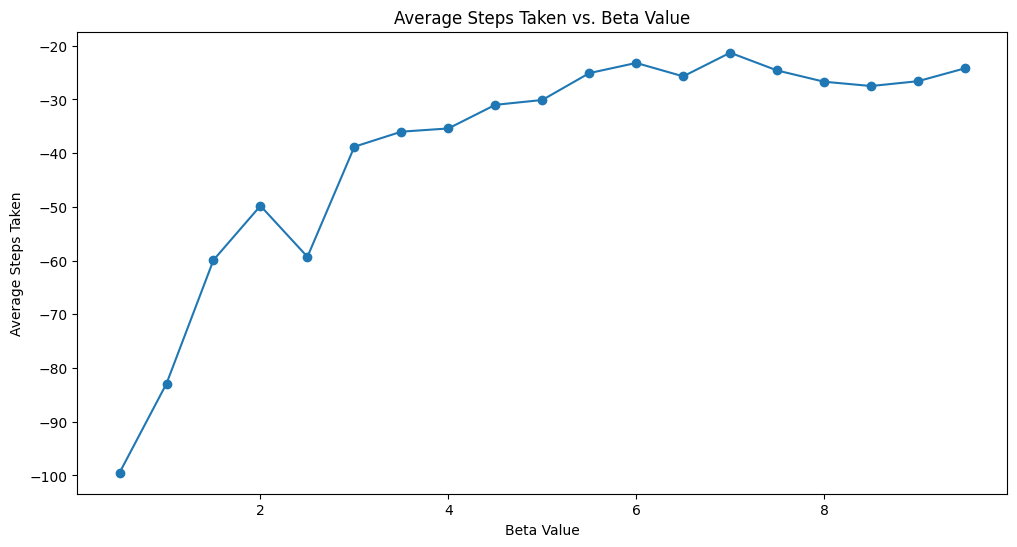

In [127]:
#plot each value in the dictionary
x = list(beta_dictionary_20.keys())    
y = list(beta_dictionary_20.values())
y_neg = [-i for i in y]
plt.figure(figsize=(12, 6))
plt.plot((x), y_neg, marker='o')
plt.xlabel('Beta Value')
plt.ylabel('Average Steps Taken')
plt.title('Average Steps Taken vs. Beta Value')
plt.xticks(list(beta_dictionary_20.keys()), rotation=45)
# plt.yticks(list(beta_dictionary.values()))
plt.show()